<a href="https://colab.research.google.com/github/brownyu/SMT203_NLP/blob/main/Lab7_topic_modeling_with_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7 - Topic Modeling

In this lab, you will learn:
* How to find topics in a corpus using topic modeling
* How to apply Latent Dirichlet Allocation (LDA), a topic modeling technique, to texts
* How to find the distribution of LDA topics in a corpus

This lab is written by Jisun AN (jisunan@smu.edu.sg) and Michelle KAN (michellekan@smu.edu.sg) based on existing tutorial, titled "[Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)," by Selva Prabhakaran. 


 

# 0. Introduction 

One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. And it’s really hard to manually read through such large volumes and compile the topics.

Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed. This is called topic modeling. The ultimate goal of topic modeling is to find various topics that are present in your corpus. Each document in the corpus will be made up of at least one topic, if not multiple topics.

In this tutorial, we will take a real example of the COVID-19 Twitter dataset and use **Latent Dirichlet Allocation (LDA)**, which is one of many topic modeling techniques. It was specifically designed for text data, to extract the naturally discussed topics.

We will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is.


In [ ]:
!pip install pyldavis
!pip install -U gensim
# !pip install en_core_web_sm

     |████████████████████████████████| 1.7MB 5.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.9MB 16.3MB/s 
     |████████████████████████████████| 15.3MB 309kB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.3.0-cp37-none-any.whl size=136817 sha256=f47a44647ec2459d56d833ddd45d2169cdec3dbe73332bafb0281eee7b7bbf1a
  Stored in directory: /root/.cache/pip/wheels/2b/19/cd/a60c0d50a1a60ae2476d00611fa87c62c5d2b7762429eb642b
Successfully built pyldavis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0

     |████████████████████████████████| 24.2MB 1.6MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


You must restart runtime after updating libraries. 

In [ ]:
import pandas as pd
import re 

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import scipy.sparse

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).ep

# 1. Getting the data

We will use the COVID-19 Twitter dataset, which is collected based on COVID-19 related keywords, including covid, coronavirus, etc from Jan to April 2020. 


In [ ]:
ori_df = pd.read_table("https://raw.githubusercontent.com/anjisun221/css_codes/main/sample_covid19_tweet_20200101_20200412_en.tsv", sep="\t")

print(ori_df.shape)
ori_df.head()

(10000, 4)


,text_no,timestampStr,user_location_state,text
0,0,2020-03-21,ca,National coronavirus updates: VP Pence and wif...
1,1,2020-03-04,ny,How are your facilities preparing for #Coronav...
2,2,2020-04-12,ct,Revealed: value of UK pandemic stockpile fell ...
3,3,2020-02-26,md,Some of the biggest threats we face are global...
4,4,2020-03-03,wa,Fitness Instagram just exploded https://t.co/a...


In [ ]:
df = ori_df.sample(n=5000, random_state=999)
print(df.shape)

(5000, 4)


In [ ]:
df.text.head()

9031    It almost like nobody has ever bought somethin...
3462    @Curly_Jazzy @HoneyDip_8 YOOOOOOO WHERE THEY A...
3863    Wear a mask if out!Make one with microfiber cl...
1144    03/04/2020 11 deaths in the USA from the #coro...
2692    If extreme measures like mass quarantines come...
Name: text, dtype: object

# (Preview) Let's build a quick LDA topic model 

In [ ]:
# Convert to list
data = df.text.values.tolist()
data[:5]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Let's start with 2 topics.
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
#passes: how many iterations going through 
lda_model.print_topics()

[(0,
  '0.036*"the" + 0.024*"to" + 0.022*"https" + 0.021*"co" + 0.015*"is" + 0.014*"and" + 0.013*"of" + 0.013*"this" + 0.011*"coronavirus" + 0.011*"in"'),
 (1,
  '0.053*"co" + 0.052*"https" + 0.029*"coronavirus" + 0.024*"the" + 0.017*"to" + 0.014*"of" + 0.013*"in" + 0.009*"and" + 0.009*"covid" + 0.009*"for"')]

In [ ]:
# Let's start with 10 topics. This may take a while.
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, passes=10)
lda_model.print_topics()

[(0,
  '0.018*"co" + 0.018*"https" + 0.006*"tweet" + 0.006*"sign" + 0.004*"pelosi" + 0.004*"learning" + 0.004*"petition" + 0.004*"thank" + 0.003*"drive" + 0.003*"bloomberg"'),
 (1,
  '0.015*"new" + 0.012*"york" + 0.006*"reading" + 0.005*"restaurants" + 0.004*"himself" + 0.004*"aoc" + 0.004*"hurt" + 0.003*"ignorant" + 0.003*"funny" + 0.003*"doors"'),
 (2,
  '0.038*"the" + 0.024*"is" + 0.023*"this" + 0.021*"of" + 0.021*"to" + 0.017*"co" + 0.017*"https" + 0.017*"and" + 0.014*"it" + 0.013*"you"'),
 (3,
  '0.018*"co" + 0.017*"https" + 0.005*"hong" + 0.004*"kong" + 0.004*"zero" + 0.003*"as" + 0.003*"bs" + 0.003*"is" + 0.003*"dead" + 0.003*"coronavirus"'),
 (4,
  '0.061*"https" + 0.053*"co" + 0.051*"none" + 0.030*"false" + 0.018*"coronavirus" + 0.014*"en" + 0.014*"wed" + 0.013*"mar" + 0.008*"com" + 0.006*"covid"'),
 (5,
  '0.005*"among" + 0.005*"oil" + 0.004*"example" + 0.004*"videos" + 0.003*"ac" + 0.003*"losses" + 0.003*"contingency" + 0.002*"aka" + 0.002*"lord" + 0.002*"competent"'),
 (6,


#### Does above topics make sense to you? 

# 2. Data cleaning

We will do the followings:
* Remove @mention and url
* Tokenization: We will use Gensim's module `gensim.utils.simple_preprocess` to tokenize the sentence in our corpus. It will convert a document into a list of tokens. Read more [here](https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html).
* Removing Stop words
* Bigram extraction- extracting list of two words frequently occurring together in the document e.g, ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.
* Lemmatization， to find the root of the word 





In [ ]:
# Convert to list
data = df.text.values.tolist()
data[:5]

['It almost like nobody has ever bought something made in China at Home Depot and have it break in 48 hours. https://t.co/zEcB0QqnGt',
 '@Curly_Jazzy @HoneyDip_8 YOOOOOOO WHERE THEY ATT 😂💀💀 https://t.co/8HYd3v7K2V',
 "Wear a mask if out!Make one with microfiber cloth inside and folded out with the best filter you can devise inside.Tie,stitch, or pin at edges.Rewear in 3 days.Fine those who don't.Don't use the medical professions N95 filters.Other countries require this. Idiots won't comply.",
 '03/04/2020 11 deaths in the USA from the #coronavirus #TrumpVirus',
 'If extreme measures like mass quarantines come to pass, #telehealth could finally have its bittersweet moment in the spotlight. The #Coronavirus Outbreak Could Finally Make #Telemedicine Mainstream https://t.co/5auM7OROtv @TIME #HumanizeHealthcare #HIMSS20 #BeTheChange https://t.co/gz4O7rtAwC']

2-1. Remove @mention and url

In [ ]:
# Remove @mentions 
data = [re.sub(r'@\w+', '', sent) for sent in data]

# Remove urls (remove a word starting with http)
data = [re.sub(r'http\S+', '', sent) for sent in data]

data[:5]

['It almost like nobody has ever bought something made in China at Home Depot and have it break in 48 hours. ',
 '  YOOOOOOO WHERE THEY ATT 😂💀💀 ',
 "Wear a mask if out!Make one with microfiber cloth inside and folded out with the best filter you can devise inside.Tie,stitch, or pin at edges.Rewear in 3 days.Fine those who don't.Don't use the medical professions N95 filters.Other countries require this. Idiots won't comply.",
 '03/04/2020 11 deaths in the USA from the #coronavirus #TrumpVirus',
 'If extreme measures like mass quarantines come to pass, #telehealth could finally have its bittersweet moment in the spotlight. The #Coronavirus Outbreak Could Finally Make #Telemedicine Mainstream   #HumanizeHealthcare #HIMSS20 #BeTheChange ']

2-2. Tokenization

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['it', 'almost', 'like', 'nobody', 'has', 'ever', 'bought', 'something', 'made', 'in', 'china', 'at', 'home', 'depot', 'and', 'have', 'it', 'break', 'in', 'hours']]


2-3. Remove stopwords

In [ ]:
# Prepare stopwords using NLTK
stop_words = stopwords.words('english')

# You can add other words to the list of stop words as well
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'amp'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
print(data_words_nostops[:1])

[['almost', 'like', 'nobody', 'ever', 'bought', 'something', 'made', 'china', 'home', 'depot', 'break', 'hours']]


2-4. Bigram extraction

In [ ]:
# Build the bigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

print(data_words_bigrams[10])

['coronavirus', 'arrived', 'washington_state', 'like', 'slap', 'face', 'nurse', 'seattle', 'area', 'told', 'read', 'story', 'hospital', 'readiness']


2-5. Lemmatization

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma .

Stemming and Lemmatization both generate the root form of the inflected words. The difference is that stem might not be an actual word whereas, lemma is an actual language word. Stemming follows an algorithm with steps to perform on the words which makes it faster.

We use Spacy for lemmatization. 
It also allows to consider terms with a particular part of speech tag.
We will use nouns (NOUN) and proper nouns (PNOUN) in this example. A proper noun is a specific name for a particular person, place, or thing. See options for part of speech here: https://spacy.io/usage/linguistic-features 



In [ ]:
def lemmatization(texts, allowed_postags=['NOUN']):
    """"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component
# For normal use
# !python -m spacy download en_core_web_sm
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# For Colab use
import en_core_web_sm
nlp = en_core_web_sm.load()

print("Before Lemmatization:", data_words_bigrams[:1])

# Do lemmatization keeping only noun
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'PROPN'])

print("After Lemmatization: ", data_lemmatized[:1])


Before Lemmatization: [['almost', 'like', 'nobody', 'ever', 'bought', 'something', 'made', 'china', 'home', 'depot', 'break', 'hours']]
After Lemmatization:  [['china', 'home', 'depot', 'break', 'hour']]


# 2. Building topic model

The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus. Let’s create them.

Gensim creates a unique id for each word in the document (id2word). Then, the produced corpus is a mapping of (word_id, word_frequency).

Check [`gensim.corpora`](https://radimrehurek.com/gensim/corpora/dictionary.html) for details about `filter_extremes()`


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=1.5, no_above=0.8) # below 1.5 times and above 80 percent  this will filter out words that are less frequen

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs once and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary (id2word).

In [ ]:
print(id2word[0], id2word[1], id2word[2], id2word[3], id2word[4])


break china depot home hour


To build LDA model, you need to specify the number of topics apart from the dictionary (id2word) and the corpus. 

Passes is the total number of training passes. The larger passes would refine the assignment of words for topics. 

Check other parameters of LDA model [here](https://radimrehurek.com/gensim/models/ldamodel.html). 

In [ ]:
# Build LDA model

# Let's start with 2 topics.
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda_model.print_topics()

[(0,
  '0.083*"coronavirus" + 0.016*"people" + 0.014*"trump" + 0.011*"china" + 0.009*"news" + 0.008*"none_en" + 0.007*"time" + 0.007*"death" + 0.006*"virus" + 0.006*"president"'),
 (1,
  '0.059*"coronavirus" + 0.036*"covid" + 0.014*"china" + 0.013*"pandemic" + 0.009*"case" + 0.008*"people" + 0.007*"state" + 0.007*"thing" + 0.007*"time" + 0.006*"virus"')]

How to interpret a LDA topic?

Topic 0 is a represented as  `0.050*"coronavirus" + 0.021*"china" + 0.011*"case" + 0.010*"virus" + 0.008*"day" + 0.007*"cdc" + 0.007*"world" + 0.007*"death" + 0.006*"covid" + 0.006*"time"`

It means the top 10 keywords that contribute to this topic are: 'coronavirus', 'china', 'case', ... and so on and the weight of 'coronavirus' on topic 0 is 0.05.

The weights reflect how important a keyword is to that topic. 

Looking at these keywords, can you guess what this topic could be? You may summarise it either are 'covid-19 update' or 'covid-19 news.'

Likewise, Topic 1 could be 'Trump' or 'politics.'


In [ ]:
# 3 topics.
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda_model.print_topics()

[(0,
  '0.047*"coronavirus" + 0.034*"people" + 0.027*"covid" + 0.015*"none_en" + 0.009*"mar_false" + 0.009*"hand" + 0.009*"pandemic" + 0.008*"world" + 0.008*"flu" + 0.008*"shit"'),
 (1,
  '0.068*"coronavirus" + 0.030*"china" + 0.014*"news" + 0.009*"time" + 0.009*"trump" + 0.007*"people" + 0.007*"covidー" + 0.007*"thing" + 0.006*"covid" + 0.006*"world"'),
 (2,
  '0.090*"coronavirus" + 0.025*"covid" + 0.015*"case" + 0.011*"trump" + 0.011*"day" + 0.010*"virus" + 0.008*"state" + 0.008*"china" + 0.006*"death" + 0.006*"president"')]

In [ ]:
# 10 topics.
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, passes=10)
lda_model.print_topics()

[(0,
  '0.087*"china" + 0.055*"coronavirus" + 0.019*"virus" + 0.016*"wuhan" + 0.016*"day" + 0.016*"medium" + 0.016*"life" + 0.015*"thank" + 0.015*"coronavirus_outbreak" + 0.014*"market"'),
 (1,
  '0.093*"coronavirus" + 0.019*"thing" + 0.015*"video" + 0.012*"fact" + 0.011*"pandemic" + 0.010*"trump" + 0.010*"god" + 0.009*"meeting" + 0.009*"lie" + 0.009*"florida"'),
 (2,
  '0.056*"coronavirus" + 0.037*"none_en" + 0.023*"mar_false" + 0.020*"covid" + 0.019*"hand" + 0.018*"today" + 0.013*"new_york" + 0.012*"time" + 0.011*"corona_virus" + 0.011*"news"'),
 (3,
  '0.027*"coronavirus" + 0.022*"people" + 0.018*"covid" + 0.017*"city" + 0.017*"event" + 0.014*"trump" + 0.013*"question" + 0.012*"pandemic" + 0.012*"leader" + 0.011*"resource"'),
 (4,
  '0.136*"coronavirus" + 0.030*"people" + 0.014*"quarantine" + 0.012*"flu" + 0.011*"test" + 0.011*"patient" + 0.011*"death" + 0.010*"time" + 0.010*"california" + 0.010*"china"'),
 (5,
  '0.069*"coronavirus" + 0.039*"trump" + 0.029*"world" + 0.028*"virus" +

# 3. Topic coference 

Model perplexity and [topic coherence](https://rare-technologies.com/what-is-topic-coherence/) provide a convenient measure to judge how good a given topic model is. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. There are two major types C_V typically 0 < x < 1 and uMass -14 < x < 14. When using c_v, the coference score of >0.5 would be considered to be good and it would be rare to see a > 0.9. See more [here](https://stackoverflow.com/questions/54762690/what-is-the-meaning-of-coherence-score-0-4-is-it-good-or-bad). 


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.536483725264657

Coherence Score:  0.3881158043061184


# 4. How to find the optimal number of topics for LDA?

To find the optimal number of topics, we will build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a 'k' that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

We will use the elbow method, a visualization of changes of coherenve value by varying k, which gives us a graph of the optimal number of topics for greatest coherence. Check out [this](https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/) for more for the elbow method.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f'Training model for num_topics= {num_topics}')
        model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
start = 2
limit = 60
step = 6

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)
print('Completed!')

Training model for num_topics= 2
Training model for num_topics= 8
Training model for num_topics= 14
Training model for num_topics= 20
Training model for num_topics= 26
Training model for num_topics= 32
Training model for num_topics= 38
Training model for num_topics= 44
Training model for num_topics= 50
Training model for num_topics= 56
Completed!


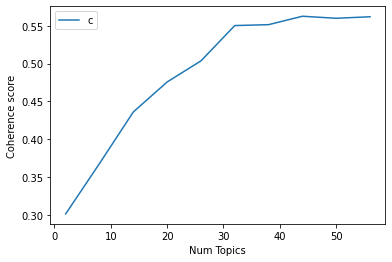

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.301
Num Topics = 8  has Coherence Value of 0.3677
Num Topics = 14  has Coherence Value of 0.436
Num Topics = 20  has Coherence Value of 0.4757
Num Topics = 26  has Coherence Value of 0.5036
Num Topics = 32  has Coherence Value of 0.5504
Num Topics = 38  has Coherence Value of 0.5516
Num Topics = 44  has Coherence Value of 0.5627
Num Topics = 50  has Coherence Value of 0.56
Num Topics = 56  has Coherence Value of 0.562


# 5. Best LDA model

So for further steps I will choose the model with 26 topics itself.
By increasing the number of passes, the topics can be refined. 

In [ ]:
best_num_topics = 26

In [ ]:
# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=best_num_topics, passes= 60)
lda_model.print_topics()


[(15,
  '0.077*"coronavirus" + 0.070*"hand" + 0.065*"shit" + 0.032*"community" + 0.030*"rate" + 0.025*"story" + 0.023*"new_york" + 0.022*"infection" + 0.021*"cdc" + 0.018*"covid"'),
 (7,
  '0.122*"coronavirus" + 0.113*"news" + 0.041*"expert" + 0.022*"covid" + 0.022*"deal" + 0.019*"chance" + 0.018*"ncov" + 0.017*"piece" + 0.012*"warning" + 0.011*"loan"'),
 (18,
  '0.075*"year" + 0.063*"china" + 0.061*"market" + 0.060*"vaccine" + 0.053*"economy" + 0.046*"job" + 0.040*"coronavirus" + 0.020*"war" + 0.020*"ohio" + 0.017*"biden"'),
 (1,
  '0.101*"coronavirus_outbreak" + 0.075*"corona" + 0.041*"relief" + 0.039*"coronavirus" + 0.031*"action" + 0.031*"hell" + 0.028*"ass" + 0.023*"republicans" + 0.019*"statement" + 0.018*"apple"'),
 (5,
  '0.091*"world" + 0.076*"coronavirus" + 0.071*"covidー" + 0.063*"business" + 0.038*"order" + 0.031*"part" + 0.024*"department" + 0.021*"covid" + 0.019*"ppl" + 0.019*"italy"'),
 (0,
  '0.193*"china" + 0.069*"virus" + 0.044*"coronavirus" + 0.044*"county" + 0.037*"o

# 6. Visualize LDA topics

pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14    -0.076346  0.135360       1        1  4.844622
10    -0.047777  0.146792       2        1  4.764977
21    -0.027545  0.040164       3        1  4.748698
0     -0.215666 -0.169140       4        1  4.743124
7      0.050631  0.063317       5        1  4.471077
2      0.058626  0.078758       6        1  4.285591
25    -0.029925  0.111408       7        1  4.157700
11     0.054531  0.002186       8        1  4.063937
22    -0.204595 -0.078089       9        1  4.011902
23     0.122434 -0.205654      10        1  4.005747
6      0.020413  0.056269      11        1  3.960224
5      0.019077  0.045263      12        1  3.875138
4      0.050775 -0.013933      13        1  3.864446
12     0.032756  0.001730      14        1  3.845762
3     -0.008247  0.107068      15        1  3.839364
19     0.064543 -0.074048      16        1  3.785006
15    -0.020366 -0.022605      17        1  3.668770
18    -0.224012 -0.102249      18        1  3.526025
8      0.106866 -0.029291      19        1  3.459061
16     0.147577 -0.143310      20        1  3.427952
24    -0.034000  0.081267      21        1  3.358617
9      0.085804  0.002271      22        1  3.286326
17     0.003003 -0.003212      23        1  3.119250
13     0.037319  0.002121      24        1  3.048822
20     0.060688 -0.075396      25        1  2.943238
1     -0.026564  0.042953      26        1  2.894622, topic_info=             Term        Freq        Total Category  logprob  loglift
53         people  321.000000   321.000000  Default  30.0000  30.0000
1           china  338.000000   338.000000  Default  29.0000  29.0000
71          trump  217.000000   217.000000  Default  28.0000  28.0000
73           time  184.000000   184.000000  Default  27.0000  27.0000
96       pandemic  169.000000   169.000000  Default  26.0000  26.0000
...           ...         ...          ...      ...      ...      ...
0           break    6.620621     9.010634  Topic26  -4.7356   3.2341
505           fee    5.992397     8.462099  Topic26  -4.8353   3.1972
1132          san    7.533212    13.508946  Topic26  -4.6065   2.9583
12    coronavirus   29.733140  1959.601295  Topic26  -3.2335  -0.6459
201            us    5.678888    86.707295  Topic26  -4.8890   0.8165

[1145 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
271      15  0.300643           _
271      19  0.661414           _
612       1  0.881473    abc_news
441      15  0.103515      access
441      23  0.828118      access
...     ...       ...         ...
56       26  0.170370   yesterday
997      26  0.868522        yike
133       9  0.793746          yo
1263     18  0.895051  zero_hedge
702      26  0.901155        zoom

[1451 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 11, 22, 1, 8, 3, 26, 12, 23, 24, 7, 6, 5, 13, 4, 20, 16, 19, 9, 17, 25, 10, 18, 14, 21, 2])

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

Upnext, we will focus on how to arrive at the optimal number of topics given any large corpus of text.

# 7. Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The `format_topics_sentences()` function below nicely aggregates this information in a presentable table.

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'topic_perc_contrib', 'keywords']
    
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)
df_topic_sents_keywords.head()


,dominant_topic,topic_perc_contrib,keywords
0,18.0,0.5064,"year, china, market, vaccine, economy, job, co..."
1,0.0,0.0385,"china, virus, coronavirus, county, outbreak, u..."
2,0.0,0.4815,"china, virus, coronavirus, county, outbreak, u..."
3,4.0,0.5611,"time, president, coronavirus, flu, covid, univ..."
4,9.0,0.5039,"quarantine, coronavirus, food, thought, child,..."


In [ ]:
# Combine the original data with inferred topics

dominant_topic = pd.Series(df_topic_sents_keywords.dominant_topic.values.tolist())
topic_perc_contrib = pd.Series(df_topic_sents_keywords.topic_perc_contrib.values.tolist())
keywords = pd.Series(df_topic_sents_keywords.keywords.values.tolist())

text_no = pd.Series(df.text_no.values.tolist())
timestampStr = pd.Series(df.timestampStr.values.tolist())
user_location_state = pd.Series(df.user_location_state.values.tolist())
text = pd.Series(df.text.values.tolist())

pd.set_option('display.max_colwidth', 150)
new_df = pd.concat([text_no, timestampStr, user_location_state, dominant_topic, topic_perc_contrib, keywords, text], axis=1)
new_df.columns = ['text_no', 'timestampStr', 'user_location_state', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']
new_df.head()


,text_no,timestampStr,user_location_state,dominant_topic,topic_perc_contrib,keywords,text
0,9031,2020-03-26,la,18.0,0.5064,"year, china, market, vaccine, economy, job, coronavirus, war, ohio, biden",It almost like nobody has ever bought something made in China at Home Depot and have it break in 48 hours. https://t.co/zEcB0QqnGt
1,3462,2020-03-15,ma,0.0,0.0385,"china, virus, coronavirus, county, outbreak, update, information, novel_coronavirus, face, concern",@Curly_Jazzy @HoneyDip_8 YOOOOOOO WHERE THEY ATT 😂💀💀 https://t.co/8HYd3v7K2V
2,3863,2020-04-01,ny,0.0,0.4815,"china, virus, coronavirus, county, outbreak, update, information, novel_coronavirus, face, concern","Wear a mask if out!Make one with microfiber cloth inside and folded out with the best filter you can devise inside.Tie,stitch, or pin at edges.Rew..."
3,1144,2020-03-04,ca,4.0,0.5611,"time, president, coronavirus, flu, covid, university, woman, cause, plague, new_york",03/04/2020 11 deaths in the USA from the #coronavirus #TrumpVirus
4,2692,2020-03-04,ca,9.0,0.5039,"quarantine, coronavirus, food, thought, child, covid, issue, social_distancing, mayor, restaurant","If extreme measures like mass quarantines come to pass, #telehealth could finally have its bittersweet moment in the spotlight. The #Coronavirus O..."


In [ ]:
new_df.dominant_topic.value_counts()

0.0     561
14.0    322
10.0    287
21.0    258
7.0     226
2.0     205
11.0    204
22.0    203
6.0     196
12.0    194
15.0    185
5.0     183
4.0     178
25.0    174
23.0    173
8.0     163
16.0    161
19.0    151
9.0     136
18.0    135
3.0     127
1.0     123
24.0    119
13.0    116
20.0    112
17.0    108
Name: dominant_topic, dtype: int64

In [ ]:
new_df.keywords.value_counts()

china, virus, coronavirus, county, outbreak, update, information, novel_coronavirus, face, concern         561
coronavirus, trump, country, mask, fact, hoax, nyc, iran, response, cnn                                    322
people, coronavirus, thing, god, bill, money, thread, house, event, meeting                                287
coronavirus, way, response, medium, march, leader, emergency, covid, ban, nation                           258
coronavirus, news, expert, covid, deal, chance, ncov, piece, warning, loan                                 226
case, coronavirus, death, number, thank, threat, press, conference, today, covid                           205
coronavirus, patient, spread, america, covid, amid_coronavirus, article, resident, disease, cruise_ship    204
coronavirus, man, wuhan, test, doctor, americans, lot, china, control, us                                  203
coronavirus, life, new, symptom, report, team, treatment, government, game, idiot                          196
c

(array([561., 123., 205., 127., 178., 183., 196., 226., 163., 136., 287.,
        204., 194., 116., 322., 185., 161., 108., 135., 151., 112., 258.,
        203., 173., 119., 174.]),
 array([ 0.        ,  0.96153846,  1.92307692,  2.88461538,  3.84615385,
         4.80769231,  5.76923077,  6.73076923,  7.69230769,  8.65384615,
         9.61538462, 10.57692308, 11.53846154, 12.5       , 13.46153846,
        14.42307692, 15.38461538, 16.34615385, 17.30769231, 18.26923077,
        19.23076923, 20.19230769, 21.15384615, 22.11538462, 23.07692308,
        24.03846154, 25.        ]),
 <a list of 26 Patch objects>)

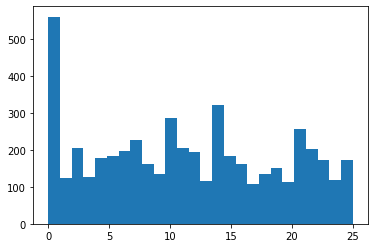

In [ ]:
plt.hist(new_df.dominant_topic, bins=best_num_topics)

# 8. Find the most representative documents for each topic. 

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. 




In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_lda = pd.DataFrame()
sent_topics_outdf_grpd = new_df.groupby('dominant_topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_lda = pd.concat([sent_topics_sorteddf_lda, 
                                             grp.sort_values(['topic_perc_contrib'], ascending=[0]).head(3)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# # Show
sent_topics_sorteddf_lda

,text_no,timestampStr,user_location_state,dominant_topic,topic_perc_contrib,keywords,text
0,2824,2020-02-28,dc,0.0,0.8798,"china, virus, coronavirus, county, outbreak, update, information, novel_coronavirus, face, concern",Coronavirus (COVID-19) Supply Chain Update @drawandstrike @catesduane @rising_serpent @COsweda @almostjingo @tracybeanz @CarrollQuigley1 @dbongino...
1,1499,2020-04-09,or,0.0,0.8397,"china, virus, coronavirus, county, outbreak, update, information, novel_coronavirus, face, concern","#ThankfulThursday I'm🙏🙏🙏for the pandemic for putting me face to face with my procrastination monster. 👹⏰⌚️👹 Ironically, I'm also, grateful for the..."
2,5379,2020-01-28,fl,0.0,0.8077,"china, virus, coronavirus, county, outbreak, update, information, novel_coronavirus, face, concern",5 Million Potential Carriers Have Left Wuhan As Coronavirus Appears To Mutate Into “More Transmissable” Form https://t.co/QJJ1end0zm
3,8813,2020-03-18,tx,1.0,0.8932,"coronavirus_outbreak, corona, relief, coronavirus, action, hell, ass, republicans, statement, apple",US Sens John Cornyn and Ted Cruz both voted for the coronavirus relief bill https://t.co/CzQprLv7yB
4,363,2020-02-18,wa,1.0,0.8773,"coronavirus_outbreak, corona, relief, coronavirus, action, hell, ass, republicans, statement, apple",Apple unlikely to meet revenue guidance due to coronavirus impact: Apple Inc said on Monday it would not meet its revenue guidance for the March q...
...,...,...,...,...,...,...,...
73,3908,2020-02-13,ca,24.0,0.8026,"coronavirus, employee, south, population, community, safety, weekend, read, white, wtf","An attempted rally is fizzling out late in the session, #DOW-117. #coronavirus concerns get some blame, but investors remain fairly confident that..."
74,1860,2020-04-04,pa,24.0,0.7596,"coronavirus, employee, south, population, community, safety, weekend, read, white, wtf",COVID-19 Stimulus Payments courtesy of David M. Spitzberg https://t.co/czb0VZWw5z
75,7576,2020-03-08,nc,25.0,0.8077,"crisis, work, health, coronavirus, family, home, help, person, worker, call",Truly horrible. #PresidentPAB has worshipers following him blindly &amp; believing his narcissistic medical advice instead of board certified phys...
76,2676,2020-04-03,ny,25.0,0.7820,"crisis, work, health, coronavirus, family, home, help, person, worker, call","Extremely sad to have lost a colleague and truly kind person to this horrid health crisis. Today is a very tough day for our city. Rest In Peace, ..."


# Exercise 1

Create a new topic model that includes terms from a different [part of speech](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) such as Adjectives and Verb and see if you can get better topics. 

After you complete and run below code, you will need to rerun almost all the above codes (from Section 2). 
See options for part of speech here: https://spacy.io/api/annotation

Question to anwser: 
Find the best LDA model. How many topics does it have? 



In [ ]:
print("Before Lemmatization:", data_words_bigrams[:1])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = #WRITE YOUR CODE

print("After Lemmatization: ", data_lemmatized[:1])


# Exercise 2

Chunksize controls how many documents are processed at a time in the LDA training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory. 

#### Exercise 2a) 
Update the `compute_coherence_values` function below (duplicated for you from Section 4) by setting the chunk size of the LdaModel.
See [Set LdaModel parameters](https://radimrehurek.com/gensim/models/ldamodel.html).

Rerun the compute_coherence_values function based on chunk sizes of 100 to 800 (both inclusive) in steps of 200. 

In [ ]:
### Update the following compute_coherence_values function to define chunk size for LdaModel 

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various document chunksize

    """
    coherence_values = []
    model_list = []
    
    for ??? in range(start, limit, step):
        print(f'Training model based on chunk size= {???}')
        model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=best_num_topics, passes=60, ???)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
### Set values of chunk size and run this cell after updating compute_coherence_values function above 

# setting values for chunk size
start = ??
limit = ??
step = ??

# Run LdaModel
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)
print('Completed')

#### Exercise 2b) 
Generate a coherence graph based on the chunk size defined and coherence values computed in Exercise 2a, where x-axis represents 
the 'Chunk Size' and y-axis represents 'Coherence score').

Question to anwser: 
According to the graph, what is the most optimal chunk size? 

In [ ]:
## Write your code below


